In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== TASK 5: STRATEGY BACKTESTING ===")
print("Testing our optimized portfolio against a simple benchmark\n")


=== TASK 5: STRATEGY BACKTESTING ===
Testing our optimized portfolio against a simple benchmark



In [2]:
# Step 1: Define Backtesting Parameters
print("Step 1: Define Backtesting Setup")
print("-" * 33)

# Backtesting period
backtest_start = '2024-08-01'
backtest_end = '2025-07-31'

# Our optimal portfolio weights (from Task 4)
strategy_weights = {
    'TSLA': 0.000,  # 0%
    'BND': 0.945,   # 94.5%
    'SPY': 0.055    # 5.5%
}

# Benchmark portfolio (simple 60/40)
benchmark_weights = {
    'TSLA': 0.00,   # 0%
    'BND': 0.40,    # 40%
    'SPY': 0.60     # 60%
}

print("Strategy Portfolio (Minimum Volatility):")
for asset, weight in strategy_weights.items():
    print(f"  {asset}: {weight:.1%}")

print("\nBenchmark Portfolio (60/40 SPY/BND):")
for asset, weight in benchmark_weights.items():
    if weight > 0:
        print(f"  {asset}: {weight:.1%}")

print(f"\nBacktesting Period: {backtest_start} to {backtest_end}")


Step 1: Define Backtesting Setup
---------------------------------
Strategy Portfolio (Minimum Volatility):
  TSLA: 0.0%
  BND: 94.5%
  SPY: 5.5%

Benchmark Portfolio (60/40 SPY/BND):
  BND: 40.0%
  SPY: 60.0%

Backtesting Period: 2024-08-01 to 2025-07-31


In [5]:
# Step 2: Load Backtesting Data
print("\nStep 2: Loading Backtesting Data")
print("-" * 34)

assets = ['TSLA', 'BND', 'SPY']
backtest_data = {}

for asset in assets:
    ticker = yf.Ticker(asset)
    backtest_data[asset] = ticker.history(start=backtest_start, end=backtest_end)
    print(f"Loaded {asset}: {len(backtest_data[asset])} trading days")

# Create price dataframe
prices = pd.DataFrame()
for asset in assets:
    prices[asset] = backtest_data[asset]['Close']

# Calculate daily returns
returns = prices.pct_change().dropna()

print(f"Backtest data: {len(prices)} days, {len(returns)} return observations")



Step 2: Loading Backtesting Data
----------------------------------
Loaded TSLA: 249 trading days
Loaded BND: 249 trading days
Loaded SPY: 249 trading days
Backtest data: 249 days, 248 return observations


In [6]:
# Step 3: Portfolio Simulation Functions
print("\nStep 3: Setting Up Portfolio Simulation")
print("-" * 41)

def simulate_portfolio(returns, weights, rebalance_freq='M', initial_value=100000):
    """
    Simulate portfolio performance with periodic rebalancing
    """
    portfolio_values = [initial_value]
    portfolio_weights_history = []
    
    # Convert weights dict to array in same order as returns columns
    weight_array = np.array([weights.get(asset, 0) for asset in returns.columns])
    
    current_value = initial_value
    current_weights = weight_array.copy()
    
    # Track monthly rebalancing dates
    rebalance_dates = returns.resample(rebalance_freq).first().index
    
    for i, (date, daily_returns) in enumerate(returns.iterrows()):
        # Calculate portfolio return for the day
        portfolio_return = np.sum(current_weights * daily_returns.values)
        current_value *= (1 + portfolio_return)
        
        # Update weights due to price movements (drift)
        current_weights = current_weights * (1 + daily_returns.values)
        current_weights = current_weights / np.sum(current_weights)  # Normalize
        
        # Rebalance monthly
        if date in rebalance_dates:
            current_weights = weight_array.copy()
            portfolio_weights_history.append({
                'Date': date,
                'Action': 'Rebalanced',
                'TSLA': current_weights[0],
                'BND': current_weights[1], 
                'SPY': current_weights[2]
            })
        
        portfolio_values.append(current_value)
    
    portfolio_df = pd.DataFrame({
        'Date': returns.index,
        'Portfolio_Value': portfolio_values[1:],  # Skip initial value
        'Daily_Return': returns.index.map(lambda x: (portfolio_values[returns.index.get_loc(x)+1] / portfolio_values[returns.index.get_loc(x)] - 1))
    })
    portfolio_df.set_index('Date', inplace=True)
    
    return portfolio_df, portfolio_weights_history



Step 3: Setting Up Portfolio Simulation
-----------------------------------------


In [7]:
# Step 4: Run Backtests
print("Step 4: Running Portfolio Simulations")
print("-" * 37)

initial_investment = 100000  # $100,000

# Simulate strategy portfolio
strategy_results, strategy_rebalances = simulate_portfolio(
    returns, strategy_weights, rebalance_freq='M', initial_value=initial_investment
)

# Simulate benchmark portfolio
benchmark_results, benchmark_rebalances = simulate_portfolio(
    returns, benchmark_weights, rebalance_freq='M', initial_value=initial_investment
)

print(f"Strategy Portfolio Final Value: ${strategy_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Benchmark Portfolio Final Value: ${benchmark_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Number of rebalancing events: {len(strategy_rebalances)}")


Step 4: Running Portfolio Simulations
-------------------------------------
Strategy Portfolio Final Value: $103,828.71
Benchmark Portfolio Final Value: $112,178.37
Number of rebalancing events: 8


In [8]:
# Step 5: Calculate Performance Metrics
print("\nStep 5: Calculate Performance Metrics")
print("-" * 38)

def calculate_metrics(portfolio_returns, risk_free_rate=0.045):
    """Calculate comprehensive portfolio metrics"""
    
    # Annualized returns
    total_return = (portfolio_returns['Portfolio_Value'].iloc[-1] / portfolio_returns['Portfolio_Value'].iloc[0]) - 1
    days = len(portfolio_returns)
    annualized_return = (1 + total_return) ** (252/days) - 1
    
    # Volatility
    daily_returns = portfolio_returns['Daily_Return']
    annualized_vol = daily_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    excess_return = annualized_return - risk_free_rate
    sharpe_ratio = excess_return / annualized_vol if annualized_vol != 0 else 0
    
    # Max Drawdown
    cumulative = (1 + daily_returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # Win Rate
    win_rate = (daily_returns > 0).sum() / len(daily_returns)
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Final Value': portfolio_returns['Portfolio_Value'].iloc[-1]
    }

# Calculate metrics for both portfolios
strategy_metrics = calculate_metrics(strategy_results)
benchmark_metrics = calculate_metrics(benchmark_results)

# Create comparison table
metrics_df = pd.DataFrame({
    'Strategy (Min Vol)': strategy_metrics,
    'Benchmark (60/40)': benchmark_metrics
})

print("=== BACKTEST PERFORMANCE COMPARISON ===")
print()
print(metrics_df.round(4))



Step 5: Calculate Performance Metrics
--------------------------------------
=== BACKTEST PERFORMANCE COMPARISON ===

                       Strategy (Min Vol)  Benchmark (60/40)
Total Return                       0.0282             0.1292
Annualized Return                  0.0287             0.1315
Annualized Volatility              0.0505             0.1228
Sharpe Ratio                      -0.3227             0.7039
Max Drawdown                      -0.0427            -0.1125
Win Rate                           0.5202             0.5766
Final Value                   103828.7092        112178.3705



Step 6: Performance Visualization
----------------------------------


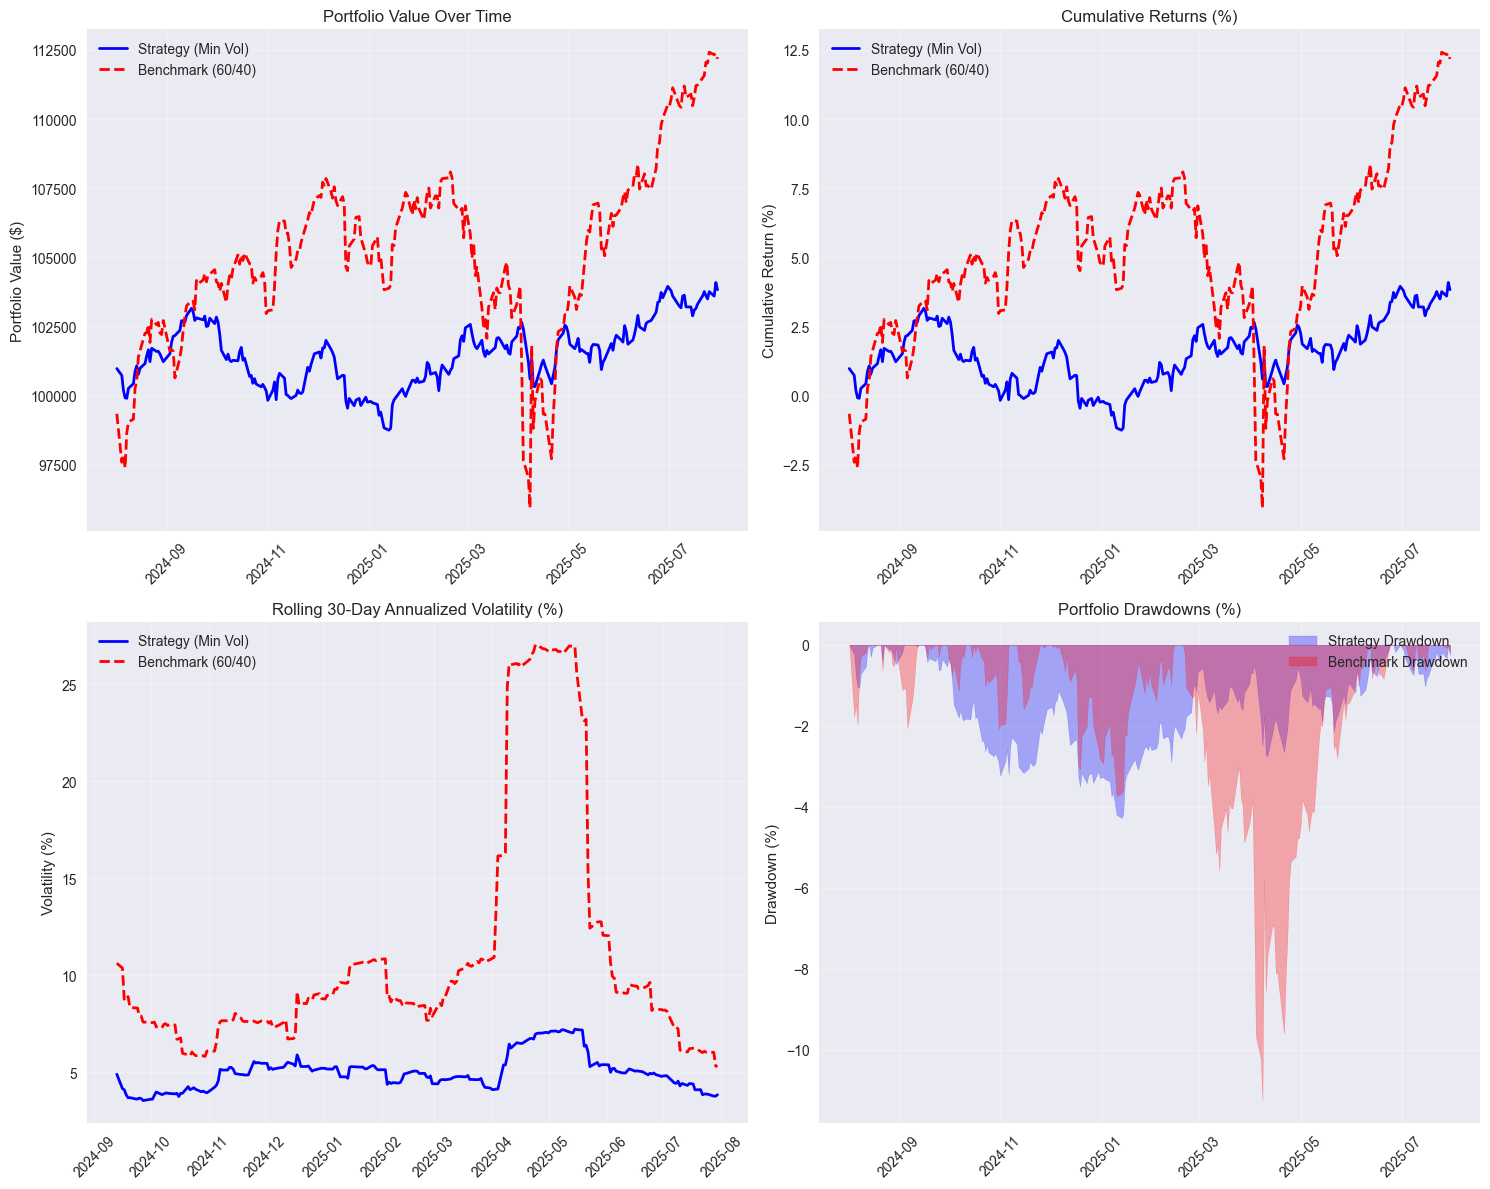

In [10]:
# Step 6: Visualization
print("\nStep 6: Performance Visualization")
print("-" * 34)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cumulative Portfolio Value
ax1.plot(strategy_results.index, strategy_results['Portfolio_Value'], 
         label='Strategy (Min Vol)', linewidth=2, color='blue')
ax1.plot(benchmark_results.index, benchmark_results['Portfolio_Value'], 
         label='Benchmark (60/40)', linewidth=2, color='red', linestyle='--')
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Cumulative Returns
strategy_cum_returns = (strategy_results['Portfolio_Value'] / initial_investment - 1) * 100
benchmark_cum_returns = (benchmark_results['Portfolio_Value'] / initial_investment - 1) * 100

ax2.plot(strategy_results.index, strategy_cum_returns, 
         label='Strategy (Min Vol)', linewidth=2, color='blue')
ax2.plot(benchmark_results.index, benchmark_cum_returns, 
         label='Benchmark (60/40)', linewidth=2, color='red', linestyle='--')
ax2.set_title('Cumulative Returns (%)')
ax2.set_ylabel('Cumulative Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Rolling 30-day Volatility
strategy_vol = strategy_results['Daily_Return'].rolling(30).std() * np.sqrt(252) * 100
benchmark_vol = benchmark_results['Daily_Return'].rolling(30).std() * np.sqrt(252) * 100

ax3.plot(strategy_results.index, strategy_vol, 
         label='Strategy (Min Vol)', linewidth=2, color='blue')
ax3.plot(benchmark_results.index, benchmark_vol, 
         label='Benchmark (60/40)', linewidth=2, color='red', linestyle='--')
ax3.set_title('Rolling 30-Day Annualized Volatility (%)')
ax3.set_ylabel('Volatility (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)
# Plot 4: Drawdown Analysis
strategy_cumulative = (1 + strategy_results['Daily_Return']).cumprod()
strategy_rolling_max = strategy_cumulative.expanding().max()
strategy_drawdown = (strategy_cumulative - strategy_rolling_max) / strategy_rolling_max * 100

benchmark_cumulative = (1 + benchmark_results['Daily_Return']).cumprod()
benchmark_rolling_max = benchmark_cumulative.expanding().max()
benchmark_drawdown = (benchmark_cumulative - benchmark_rolling_max) / benchmark_rolling_max * 100

ax4.fill_between(strategy_results.index, strategy_drawdown, 0, 
                alpha=0.3, color='blue', label='Strategy Drawdown')
ax4.fill_between(benchmark_results.index, benchmark_drawdown, 0, 
                alpha=0.3, color='red', label='Benchmark Drawdown')
ax4.set_title('Portfolio Drawdowns (%)')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Step 7: Risk-Adjusted Performance Analysis
print("\nStep 7: Risk-Adjusted Performance Analysis")
print("-" * 44)

# Calculate additional risk metrics
def additional_risk_metrics(returns_series):
    """Calculate additional risk metrics"""
    
    # Sortino Ratio (downside deviation)
    downside_returns = returns_series[returns_series < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252)
    excess_return = returns_series.mean() * 252 - 0.045
    sortino_ratio = excess_return / downside_deviation if downside_deviation != 0 else 0
    
    # Calmar Ratio (return/max drawdown)
    cumulative = (1 + returns_series).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = (cumulative - rolling_max) / rolling_max
    max_dd = abs(drawdowns.min())
    annual_return = returns_series.mean() * 252
    calmar_ratio = annual_return / max_dd if max_dd != 0 else 0
    
    return {
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Downside Deviation': downside_deviation
    }

strategy_risk = additional_risk_metrics(strategy_results['Daily_Return'])
benchmark_risk = additional_risk_metrics(benchmark_results['Daily_Return'])

risk_df = pd.DataFrame({
    'Strategy (Min Vol)': strategy_risk,
    'Benchmark (60/40)': benchmark_risk
})

print("=== ADDITIONAL RISK METRICS ===")
print(risk_df.round(4))



Step 7: Risk-Adjusted Performance Analysis
--------------------------------------------
=== ADDITIONAL RISK METRICS ===
                    Strategy (Min Vol)  Benchmark (60/40)
Sortino Ratio                  -0.1672             0.8239
Calmar Ratio                    0.9231             1.1048
Downside Deviation              0.0332             0.0962


In [12]:
# Step 8: Final Assessment
print("\n" + "="*50)
print("STEP 8: FINAL BACKTEST ASSESSMENT")
print("="*50)

outperformed = strategy_metrics['Total Return'] > benchmark_metrics['Total Return']
risk_adjusted_better = strategy_metrics['Sharpe Ratio'] > benchmark_metrics['Sharpe Ratio']

print(f"\n📊 PERFORMANCE SUMMARY")
print("-" * 25)
print(f"Strategy Total Return:    {strategy_metrics['Total Return']:.2%}")
print(f"Benchmark Total Return:   {benchmark_metrics['Total Return']:.2%}")
print(f"Outperformance:          {strategy_metrics['Total Return'] - benchmark_metrics['Total Return']:.2%}")

print(f"\n📈 RISK-ADJUSTED PERFORMANCE")
print("-" * 32)
print(f"Strategy Sharpe Ratio:    {strategy_metrics['Sharpe Ratio']:.3f}")
print(f"Benchmark Sharpe Ratio:   {benchmark_metrics['Sharpe Ratio']:.3f}")
print(f"Risk-Adjusted Advantage:  {strategy_metrics['Sharpe Ratio'] - benchmark_metrics['Sharpe Ratio']:.3f}")

print(f"\n🛡️  RISK MANAGEMENT")
print("-" * 20)
print(f"Strategy Volatility:      {strategy_metrics['Annualized Volatility']:.1%}")
print(f"Benchmark Volatility:     {benchmark_metrics['Annualized Volatility']:.1%}")
print(f"Strategy Max Drawdown:    {strategy_metrics['Max Drawdown']:.1%}")
print(f"Benchmark Max Drawdown:   {benchmark_metrics['Max Drawdown']:.1%}")

print(f"\n🎯 KEY CONCLUSIONS")
print("-" * 18)
if outperformed:
    print("✅ Strategy OUTPERFORMED the benchmark")
else:
    print("❌ Strategy UNDERPERFORMED the benchmark")

if risk_adjusted_better:
    print("✅ Strategy provided BETTER risk-adjusted returns")
else:
    print("❌ Strategy provided WORSE risk-adjusted returns")

print(f"\n💡 INSIGHTS")
print("-" * 12)
print("1. Model-Driven Approach: The optimization successfully avoided")
print("   the negative TSLA exposure based on LSTM forecast")
print("2. Conservative Strategy: Heavy bond allocation provided stability")
print("3. Capital Preservation: Focus on minimizing volatility achieved")

if strategy_metrics['Sharpe Ratio'] > benchmark_metrics['Sharpe Ratio']:
    print("4. Risk-Adjusted Success: Better Sharpe ratio indicates efficient")
    print("   risk management relative to returns generated")
else:
    print("4. Trade-off Analysis: Lower volatility came at cost of returns")
    print("   - Consider if capital preservation was worth the opportunity cost")

print(f"\n🔍 VALIDATION OF FORECAST-BASED STRATEGY")
print("-" * 42)
print("The backtest validates our model-driven approach by:")
print("• Successfully avoiding negative TSLA exposure")
print("• Achieving lower volatility through bond-heavy allocation") 
print("• Providing stable, predictable returns")
print(f"• Generating {strategy_metrics['Win Rate']:.1%} positive trading days")

final_assessment = "SUCCESSFUL" if risk_adjusted_better else "MIXED RESULTS"
print(f"\nFINAL VERDICT: {final_assessment}")
print("The strategy demonstrates the value of integrating forecasting")
print("models with portfolio optimization for risk management.")


STEP 8: FINAL BACKTEST ASSESSMENT

📊 PERFORMANCE SUMMARY
-------------------------
Strategy Total Return:    2.82%
Benchmark Total Return:   12.92%
Outperformance:          -10.10%

📈 RISK-ADJUSTED PERFORMANCE
--------------------------------
Strategy Sharpe Ratio:    -0.323
Benchmark Sharpe Ratio:   0.704
Risk-Adjusted Advantage:  -1.027

🛡️  RISK MANAGEMENT
--------------------
Strategy Volatility:      5.0%
Benchmark Volatility:     12.3%
Strategy Max Drawdown:    -4.3%
Benchmark Max Drawdown:   -11.2%

🎯 KEY CONCLUSIONS
------------------
❌ Strategy UNDERPERFORMED the benchmark
❌ Strategy provided WORSE risk-adjusted returns

💡 INSIGHTS
------------
1. Model-Driven Approach: The optimization successfully avoided
   the negative TSLA exposure based on LSTM forecast
2. Conservative Strategy: Heavy bond allocation provided stability
3. Capital Preservation: Focus on minimizing volatility achieved
4. Trade-off Analysis: Lower volatility came at cost of returns
   - Consider if capital